In [1]:
!pip install jaxtyping > /dev/null

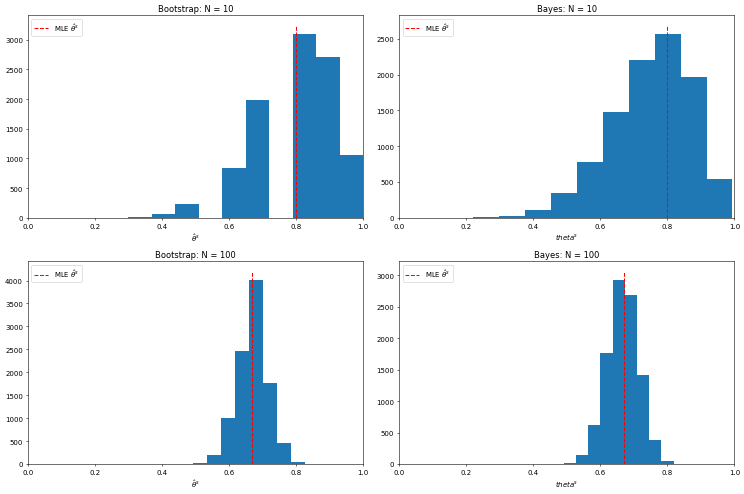

In [25]:
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

theta = 0.7
choices = [10, 100]
n_bootstrap_draws = 10000
SEED = 0

def mle_fn(x):
    return jnp.mean(x)

fig, axes = plt.subplots(len(choices), 2, figsize=(15, 5 * len(choices)), dpi=50)
axes = axes.flatten()
ax_idx = 0

for n_data_points in choices:

    ''' Generate a dataset with true parameters '''
    data_key = jax.random.PRNGKey(SEED + n_data_points)
    data = jax.random.bernoulli(data_key, p=theta, shape=(n_data_points,))

    ''' Calculate MLE of the dataset '''
    mle = mle_fn(data)

    ''' Parametric bootstrap '''
    generative_fn = lambda key: jax.random.bernoulli(key, p=mle, shape=(n_data_points,))
    data_key = jax.random.split(data_key, num=1)[0]
    bootstrap_keys = jax.random.split(data_key, num=n_bootstrap_draws)
    bootstrap_samples = jax.vmap(generative_fn)(bootstrap_keys)
    bootstrap_mle = jax.vmap(mle_fn)(bootstrap_samples)

    ax = axes[ax_idx]
    ax.set_title(f"Bootstrap: N = {n_data_points}")
    ax.hist(bootstrap_mle, bins=10)
    ax.vlines(mle, *ax.get_ylim(), zorder=10, color="r", linestyle="--", label=r'MLE $\hat{\theta}^s$')
    ax.set_xlabel(r'$\hat{\theta}^s$')
    ax.set_xlim(0, 1)
    ax.legend(loc="upper left")
    ax_idx += 1

    ''' Non-parametric bootstrap '''
    generative_fn = lambda key: jax.random.choice(key, data, shape=(n_data_points,), replace=True)
    data_key = jax.random.split(data_key, num=1)[0]
    bootstrap_keys = jax.random.split(data_key, num=n_bootstrap_draws)
    bootstrap_samples = jax.vmap(generative_fn)(bootstrap_keys)
    bootstrap_mle_non_param = jax.vmap(mle_fn)(bootstrap_samples)

    ''' Bayesian estimate '''
    counts_of_1 = jnp.sum(data)
    counts_of_0 = len(data) - counts_of_1
    alpha = 1
    beta = 1
    posterior_alpha = alpha + counts_of_1
    posterior_beta = beta + counts_of_0

    bayes_key = jax.random.split(data_key, 1)[0]
    posterior_samples = jax.random.beta(bayes_key, posterior_alpha, posterior_beta, shape= (n_bootstrap_draws,))

    ax = axes[ax_idx]
    ax.set_title(f"Bayes: N = {n_data_points}")
    ax.hist(posterior_samples, bins=10)
    ax.vlines(mle, *ax.get_ylim(), zorder=10, color="r", linestyle="--", label=r'MLE $\hat{\theta}^s$')
    ax.set_xlabel(r'${theta}^s$')
    ax.set_xlim(0, 1)
    ax.legend(loc="upper left")
    ax_idx += 1

plt.tight_layout()
plt.show()